# JQA Network — Poisson

In [1]:
import re, json, warnings
import pandas as pd
import numpy as np
from operator import itemgetter
from collections import Counter

# Sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import linear_model
from sklearn.metrics import mean_poisson_deviance
from sklearn.compose import ColumnTransformer

# Network & statistics libraries.
import networkx as nx
from networkx.readwrite import json_graph
import nxviz as nxv
from scipy.stats import skew, skewtest, powerlaw

# Primary visualizations
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

# Ignore simple warnings.
warnings.simplefilter('ignore')

# Declare directory location to shorten filepaths later.
abs_dir = "/Users/quinn.wi/Documents/"

## Import Data

In [2]:
%%time

# Read in file; select columns; drop rows with NA values (entries without a named person).
df = pd.read_csv(abs_dir + 'Data/Output/ParsedXML/JQA_dataframe.txt',
                 sep = '\t')[['entry', 'people']] \
    .dropna()

# Split string of people into individuals.
df['people'] = df['people'].str.split(r',|;')

# Explode list so that each list value becomes a row.
df = df.explode('people')


df = df.pivot_table(index = 'entry', columns = 'people', aggfunc = len, fill_value = 0) 

# \
#     .reset_index()

# df = df.set_index('entry').reset_index()


# # Create entry-person matrix.
# df = pd.crosstab(df['entry'], df['people'])

# # Convert entry-person matrix into an adjacency matrix of persons.
# df = df.T.dot(df)

# # Change diagonal values to zero. That is, a person cannot co-occur with themself.
# np.fill_diagonal(df.values, 0)

# # Create new 'source' column that corresponds to index (person).
# df['source'] = df.index

# df = df.reset_index()

df.head()

CPU times: user 1.62 s, sys: 98.1 ms, total: 1.72 s
Wall time: 1.73 s


people,Ishbosheth,Willis Alston,abbot-benjamin,abbot-joel,abbot-joel2,abbot-joseph,abbot-unknown,abbott-joel,abbott-joseph,abdon,...,young-unknown5,yriarte-unknown,yuan-ruan,zaeb-unknown,zaeb-unknown2,zea-francisco,zeabermudez-unknown,zekiel homespun,ziba,zozaya-jose
entry,,,,,,,,,,,,,,,,,,,,,
jqadiaries-v23-1821-05-07,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
jqadiaries-v23-1821-05-08,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
jqadiaries-v23-1821-05-09,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
jqadiaries-v23-1821-05-10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
jqadiaries-v23-1821-05-12,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Measure Poisson Coefficients

In [3]:
%%time

# Scale data.
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df.to_numpy())

# Declare model.
clf = linear_model.PoissonRegressor()


coefs = []
columns = dict(enumerate(df.columns))

for k, v in columns.items():
    source = v
    
    source_info = scaled[:, k]                      # Select 'k' column from data.
    subset = np.delete(scaled, k, 1)                # Drop 'k' column from scaled data.
    col_coefs = clf.fit( subset, source_info).coef_ # Measure coefficients.
    
    
#     Create dictionary of scores, retaining columns key
    scores = list(columns.keys())
    scores.remove(k)
    scores = dict( zip( scores, col_coefs))
    
    for j, u in scores.items():
        target = columns[j]
        weight = u
        
        data = {
            'source': source,
            'target': target,
            'weight': weight
        }

        coefs.append(data)

coefs = pd.DataFrame(coefs) \
    .query('weight > 0') # Following, SDFB.

coefs.head()

CPU times: user 27min 48s, sys: 1min 31s, total: 29min 20s
Wall time: 5min 33s


,source,target,weight
9,Ishbosheth,abner,0.000546
22,Ishbosheth,adams-charles2,0.000521
415,Ishbosheth,biddle-nicholas,0.000269
436,Ishbosheth,black-alexander,0.000546
567,Ishbosheth,brent-daniel,0.000244


## Filter For Testing

In [4]:
%%time

print (min(coefs['weight']), max(coefs['weight']))

# Scale data.
scaler = StandardScaler()
coefs['weight'] = scaler.fit_transform( coefs[['weight']] )

print (min(coefs['weight']), max(coefs['weight']))

coefs.head()

2.7027474310527e-20 0.03694731939170485
-1.352729402564404 90.5308021147218
CPU times: user 122 ms, sys: 3.93 ms, total: 126 ms
Wall time: 125 ms


,source,target,weight
9,Ishbosheth,abner,0.006239
22,Ishbosheth,adams-charles2,-0.057695
415,Ishbosheth,biddle-nicholas,-0.683281
436,Ishbosheth,black-alexander,0.006239
567,Ishbosheth,brent-daniel,-0.745357


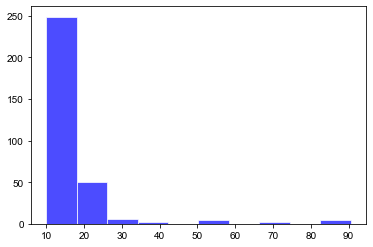

CPU times: user 140 ms, sys: 14.7 ms, total: 154 ms
Wall time: 171 ms


In [5]:
%%time

fig, ax = plt.subplots()
sns.set( rc={'figure.figsize': (18, 6)})

counts, bins = np.histogram(coefs.query('weight > 10')['weight'])

plt.hist(bins[:-1], bins, weights = counts,
         facecolor = 'blue', alpha = 0.7)

plt.show()

In [6]:
%%time

print (f'Dataframe before pruning: {coefs.shape}')
coefs = pd.DataFrame(coefs).query('weight > 10')

coefs = coefs.query('source != target')
print (f'Dataframe after pruning: {coefs.shape}\n')

Dataframe before pruning: (344296, 3)
Dataframe after pruning: (317, 3)

CPU times: user 7.59 ms, sys: 1.82 ms, total: 9.41 ms
Wall time: 6.99 ms


## Centrality

In [7]:
%%time

G = nx.from_pandas_edgelist(coefs, 
                            edge_attr = True, # Optional (consequential?) arguments here & below.
                            create_using = nx.DiGraph())


nodes = list( dict.fromkeys(coefs['source'].values.tolist() + coefs['target'].values.tolist()))
nodes = pd.DataFrame(nodes, columns = ['source'])

G.add_nodes_from(nodes)

# Measure centrality
betweenness_dict = nx.betweenness_centrality(G) # Run betweenness centrality
eigenvector_dict = nx.eigenvector_centrality(G) # Run eigenvector centrality
degree_centrality_dict = nx.degree_centrality(G) # Run degree centrality

# Assign each to an attribute in your network
nx.set_node_attributes(G, betweenness_dict, 'betweenness')
nx.set_node_attributes(G, eigenvector_dict, 'eigenvector')
nx.set_node_attributes(G, degree_centrality_dict, 'degree_centrality')

print (nx.info(G))

Name: 
Type: DiGraph
Number of nodes: 111
Number of edges: 317
Average in degree:   2.8559
Average out degree:   2.8559
CPU times: user 24.4 ms, sys: 860 µs, total: 25.3 ms
Wall time: 24.7 ms


### Summary Statistics

In [8]:
%%time

degree_dict = dict(G.degree(G.nodes()))
nx.set_node_attributes(G, degree_dict, 'degree')

sorted_degree = sorted(degree_dict.items(), key=itemgetter(1), reverse=True)

print("Top 5 nodes by degree:")
for d in sorted_degree[:5]:
    print(d)

nodes_links = coefs.merge(nodes, on = 'source', how = 'inner')
nodes_links.describe(include = 'all')

Top 5 nodes by degree:
('calhoun-john', 52)
('southard-samuel', 28)
('cook-daniel', 24)
('webster-daniel', 22)
('brown-jacob', 20)
CPU times: user 11.9 ms, sys: 2.19 ms, total: 14.1 ms
Wall time: 15.7 ms


,source,target,weight
count,317,317,317.000000
unique,110,110,NaN
top,calhoun-john,calhoun-john,NaN
freq,26,26,NaN
mean,NaN,NaN,16.200437
std,NaN,NaN,11.180527
min,NaN,NaN,10.014231
25%,NaN,NaN,11.092357
50%,NaN,NaN,12.971334
75%,NaN,NaN,16.758862


### Centrality Measurements

In [9]:
%%time

# Construct dataframe from list of dictionaries.
centrality = [betweenness_dict, 
              eigenvector_dict, 
              degree_centrality_dict]

centrality = {k: [d[k] for d in centrality] for k in centrality[0]}

centrality = pd.DataFrame(
    centrality.items(),
    columns = ['source', 'centrality']
)

# Separate column values.
centrality[['betweenness', 'eigenvector', 'degree_centrality']] = pd.DataFrame(centrality['centrality'].tolist(),
                                                                               index = centrality.index)
centrality = centrality.drop(columns = ['centrality'])

# Join with degree info
sorted_degree_df = pd.DataFrame(sorted_degree, columns = ['source', 'degree'])

centrality = centrality.merge(sorted_degree_df, on = 'source', how = 'inner')

centrality.describe()

CPU times: user 16.8 ms, sys: 1.75 ms, total: 18.5 ms
Wall time: 18.1 ms


,betweenness,eigenvector,degree_centrality,degree
count,111.000000,1.110000e+02,111.000000,111.000000
mean,0.013973,5.435434e-02,0.051925,5.711712
std,0.037653,7.816430e-02,0.061222,6.734426
min,0.000000,7.241009e-27,0.000000,0.000000
25%,0.000000,2.527465e-03,0.018182,2.000000
50%,0.000000,2.017364e-02,0.018182,2.000000
75%,0.014012,7.087372e-02,0.054545,6.000000
max,0.299267,4.895844e-01,0.472727,52.000000


#### Betweenness Ranking

CPU times: user 810 ms, sys: 29 ms, total: 839 ms
Wall time: 176 ms


[None, None]

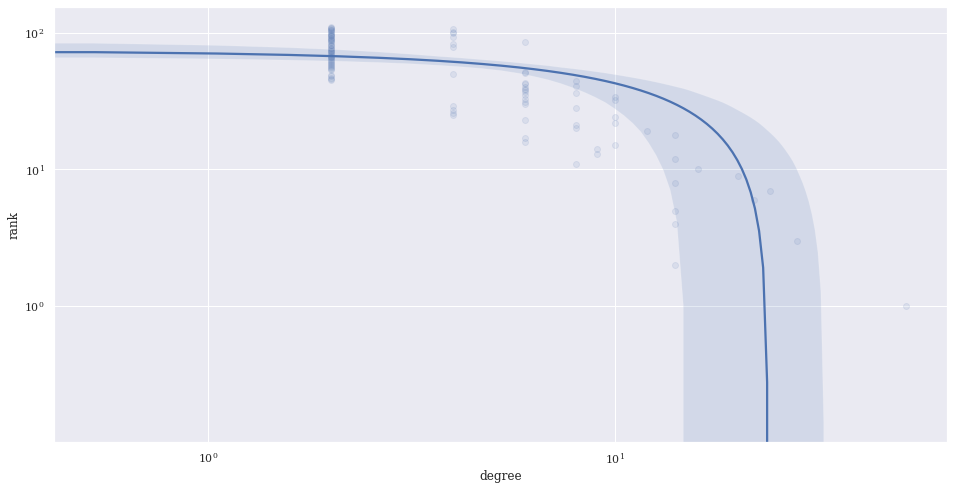

In [10]:
%%time

# Rank betweenness

betweenness_ranking = centrality.sort_values(by = ['betweenness'], ascending = False).reset_index()
betweenness_ranking['rank'] = betweenness_ranking.index + 1

# Assign betweenness rank.

betweenness_rank = dict( zip( betweenness_ranking['source'], betweenness_ranking['rank']))
nx.set_node_attributes(G, betweenness_rank, 'betweenness_rank')


# Plot

font = {'family': 'serif', 'weight': 'normal', 'size': 16}
plt.rc('font', **font)
plt.figure(figsize = (16, 8))

ax = sns.regplot(data = betweenness_ranking,
                 x = 'degree', y = 'rank',
                 scatter_kws = {'alpha': 0.1}
                )

ax.set(xscale="log", yscale="log")

In [11]:
betweenness_ranking \
    .query('(rank < 100)') \
    .sort_values(by = ['degree'], ascending = True)

,index,source,betweenness,eigenvector,degree_centrality,degree,rank
71,76,eustis-caroline,0.000000,2.765248e-03,0.018182,2,72
69,93,jennings-jonathan,0.000000,1.943743e-18,0.018182,2,70
68,99,salazar-unknown,0.000000,1.943743e-18,0.018182,2,69
67,92,madison-james,0.000000,1.943743e-18,0.018182,2,68
66,91,jefferson-thomas,0.000000,1.943743e-18,0.018182,2,67
...,...,...,...,...,...,...,...
8,38,brown-jacob,0.047215,2.261350e-01,0.181818,20,9
5,36,webster-daniel,0.063249,3.101370e-01,0.200000,22,6
6,30,cook-daniel,0.057240,2.195974e-01,0.218182,24,7
2,39,southard-samuel,0.144535,3.087216e-01,0.254545,28,3


### Degree Distribution

Creating histogram...
CPU times: user 15.2 ms, sys: 2.12 ms, total: 17.3 ms
Wall time: 15.8 ms


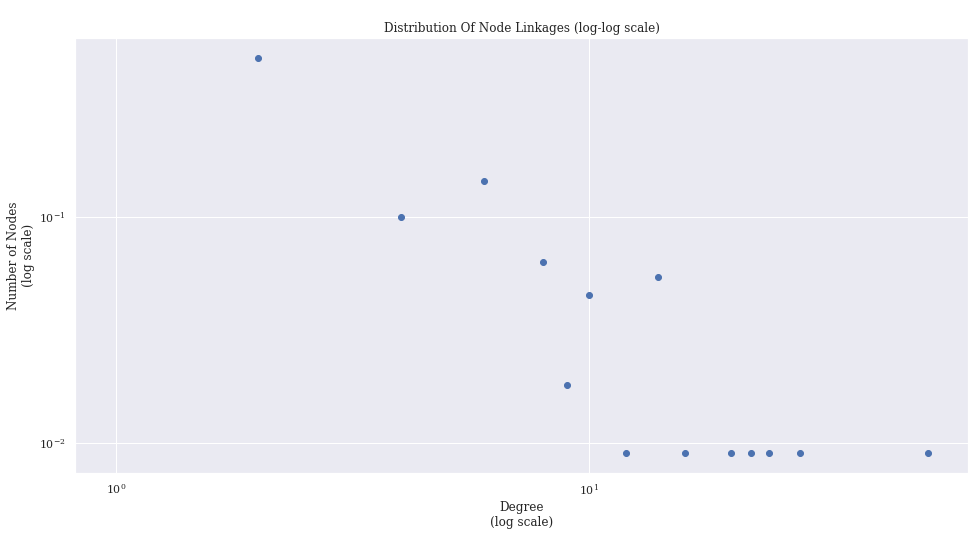

In [12]:
%%time

# https://stackoverflow.com/questions/65028854/plot-degree-distribution-in-log-log-scale

def plot_degree_histogram(g, normalized=True):
    print("Creating histogram...")
    
    aux_y = nx.degree_histogram(g)
    aux_x = np.arange(0,len(aux_y)).tolist()
    
    n_nodes = g.number_of_nodes()
    
    if normalized:
        for i in range(len(aux_y)):
            aux_y[i] = aux_y[i] / n_nodes
    
    return aux_x, aux_y


aux_x, aux_y = plot_degree_histogram(G)

# Plot

font = {'family': 'serif', 'weight': 'normal', 'size': 16}
plt.rc('font', **font)
plt.figure(figsize = (16, 8))

plt.title('\nDistribution Of Node Linkages (log-log scale)')
plt.xlabel('Degree\n(log scale)')
plt.ylabel('Number of Nodes\n(log scale)')

plt.xscale("log")
plt.yscale("log")
plt.plot(aux_x, aux_y, 'o')

## Filter for Ego Network

In [14]:
%%time

H = nx.ego_graph(G, 'calhoun-john', radius = 1)

print (nx.info(H))

Name: 
Type: DiGraph
Number of nodes: 27
Number of edges: 90
Average in degree:   3.3333
Average out degree:   3.3333
CPU times: user 803 µs, sys: 58 µs, total: 861 µs
Wall time: 894 µs


## Save (ego) Network

In [15]:
%%time

with open( abs_dir + "GitHub/dsg-mhs/d3/Network/jqa_coef-network-ego.json", "w") as outfile:
    outfile.write( json.dumps( json_graph.node_link_data(H)))

CPU times: user 892 µs, sys: 706 µs, total: 1.6 ms
Wall time: 1 ms
